In [4]:
import itertools
import random
import time
from copy import deepcopy

def brute_force(execution_times, m, max_time=5):
    T = len(execution_times)
    
    start = time.time()
    
    # Provera vremena trajanja
    if m ** T > 100000:
        return None, "Over time limit"

    best_schedule = None
    best_makespan = float('inf')

    for schedule in itertools.product(range(m), repeat=T):
        current_makespan = calculate_completion_time(schedule, execution_times, m)
        if current_makespan < best_makespan:
            best_schedule = schedule
            best_makespan = current_makespan
        
        if time.time() - start > max_time:
            return None, "Over limit (5sec)"
    
    return best_schedule, best_makespan


def local_search(execution_times, m, max_iterations):
    T = len(execution_times)
    schedule = [random.randint(0, m - 1) for _ in range(T)]
    current_makespan = calculate_completion_time(schedule, execution_times, m)
    best_schedule = schedule[:]
    best_makespan = current_makespan

    for _ in range(max_iterations):
        new_schedule = schedule[:]
        task = random.randint(0, T - 1)
        new_schedule[task] = random.randint(0, m - 1)

        new_makespan = calculate_completion_time(new_schedule, execution_times, m)
        if new_makespan < current_makespan:
            schedule = new_schedule
            current_makespan = new_makespan

        if new_makespan < best_makespan:
            best_schedule = new_schedule[:]
            best_makespan = new_makespan

    return best_schedule, best_makespan


def simulated_annealing(execution_times, m, max_iterations):
    T = len(execution_times)
    schedule = [random.randint(0, m - 1) for _ in range(T)]
    current_makespan = calculate_completion_time(schedule, execution_times, m)
    best_schedule = schedule[:]
    best_makespan = current_makespan

    for i in range(1, max_iterations):
        new_schedule = schedule[:]
        task = random.randint(0, T - 1)
        new_schedule[task] = random.randint(0, m - 1)

        new_makespan = calculate_completion_time(new_schedule, execution_times, m)
        if new_makespan < current_makespan or random.uniform(0, 1) < 1.0 / i ** 0.5:
            schedule = new_schedule
            current_makespan = new_makespan

            if new_makespan < best_makespan:
                best_schedule = new_schedule[:]
                best_makespan = new_makespan

    return best_schedule, best_makespan


class Individual:
    def __init__(self, T, m, execution_times):
        self.code = [random.randint(0, m - 1) for _ in range(T)]
        self.execution_times = execution_times
        self.m = m
        self.calc_fitness()

    def calc_fitness(self):
        processor_times = [0] * self.m
        for task, processor in enumerate(self.code):
            processor_times[processor] += self.execution_times[task][processor]
        makespan = max(processor_times)
        self.fitness = -makespan

def selection(population, k):
    k = min(len(population), k)
    participants = random.sample(population, k)
    return max(participants, key=lambda x: x.fitness)

def crossover(parent1, parent2, child1, child2):
    breakpoint = random.randrange(1, len(parent1.code))
    child1.code[:breakpoint] = parent1.code[:breakpoint]
    child1.code[breakpoint:] = parent2.code[breakpoint:]

    child2.code[:breakpoint] = parent2.code[:breakpoint]
    child2.code[breakpoint:] = parent1.code[breakpoint:]

def mutation(child, p):
    for i in range(len(child.code)):
        if random.random() < p:
            child.code[i] = random.randint(0, child.m - 1)

def genetic_algorithm(T, m, execution_times, population_size, num_generations, tournament_size, mutation_prob, elitism_size):
    population = [Individual(T, m, execution_times) for _ in range(population_size)]
    new_population = [Individual(T, m, execution_times) for _ in range(population_size)]

    if elitism_size % 2 != population_size % 2:
        elitism_size += 1

    for _ in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = deepcopy(population[:elitism_size])

        for i in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)

            crossover(parent1, parent2, new_population[i], new_population[i + 1])
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i + 1], mutation_prob)

            new_population[i].calc_fitness()
            new_population[i + 1].calc_fitness()

        population = deepcopy(new_population)

    best_individual = max(population, key=lambda x: x.fitness)
    return best_individual.code, -best_individual.fitness

def calculate_completion_time(schedule, execution_times, m):
    processor_times = [0] * m
    for task, processor in enumerate(schedule):
        processor_times[processor] += execution_times[task][processor]
    return max(processor_times)

def generate_tasks(T, m, max_time=10):
    return [[random.randint(1, max_time) for _ in range(m)] for _ in range(T)]

def run_experiment(T, m, execution_times, max_iterations, population_size, num_generations, tournament_size, mutation_prob, elitism_size):
    results = {}
    
    # Brute Force
    start = time.time()
    schedule, makespan = brute_force(execution_times, m)
    end = time.time()
    if schedule is None:
        results["Brute Force"] = makespan
    else:
        results["Brute Force"] = {"Schedule": schedule, "Makespan": makespan, "Time": end - start}
    
    # Local Search
    start = time.time()
    schedule, makespan = local_search(execution_times, m, max_iterations)
    end = time.time()
    results["Local Search"] = {"Schedule": schedule, "Makespan": makespan, "Time": end - start}

    # Simulated Annealing
    start = time.time()
    schedule, makespan = simulated_annealing(execution_times, m, max_iterations)
    end = time.time()
    results["Simulated Annealing"] = {"Schedule": schedule, "Makespan": makespan, "Time": end - start}

    # Genetic Algorithm
    start = time.time()
    schedule, makespan = genetic_algorithm(T, m, execution_times, population_size, num_generations, tournament_size, mutation_prob, elitism_size)
    end = time.time()
    results["Genetic Algorithm"] = {"Schedule": schedule, "Makespan": makespan, "Time": end - start}

    return results

problem_sizes = [(10,2),(10, 3), (12, 3), (14, 3), (16, 3), (18, 3), (20, 4), 
                 (25, 4), (30, 5), (35, 5), (40, 6), (50, 6), (60, 7), (70, 7),
                 (80, 8), (90, 9), (100,10), (200,20)]

max_iterations = 1000
population_size = 50
num_generations = 100
tournament_size = 3
mutation_prob = 0.2
elitism_size = 5

for T, m in problem_sizes:
    execution_times = generate_tasks(T, m)
    print(f"\nProblem size: T={T}, m={m}")
    results = run_experiment(T, m, execution_times, max_iterations, population_size, num_generations, tournament_size, mutation_prob, elitism_size)
    for algo, res in results.items():
        if isinstance(res, dict):
            print(f"{algo}: Makespan={res['Makespan']}, Time={res['Time']:.2f}s")
        else:
            print(f"{algo}: {res}")


Problem size: T=10, m=2
Brute Force: Makespan=24, Time=0.00s
Local Search: Makespan=31, Time=0.01s
Simulated Annealing: Makespan=25, Time=0.01s
Genetic Algorithm: Makespan=24, Time=0.34s

Problem size: T=10, m=3
Brute Force: Makespan=16, Time=0.12s
Local Search: Makespan=20, Time=0.00s
Simulated Annealing: Makespan=17, Time=0.00s
Genetic Algorithm: Makespan=16, Time=0.15s

Problem size: T=12, m=3
Brute Force: Over time limit
Local Search: Makespan=16, Time=0.00s
Simulated Annealing: Makespan=15, Time=0.00s
Genetic Algorithm: Makespan=14, Time=0.18s

Problem size: T=14, m=3
Brute Force: Over time limit
Local Search: Makespan=26, Time=0.00s
Simulated Annealing: Makespan=20, Time=0.00s
Genetic Algorithm: Makespan=17, Time=0.19s

Problem size: T=16, m=3
Brute Force: Over time limit
Local Search: Makespan=32, Time=0.00s
Simulated Annealing: Makespan=25, Time=0.00s
Genetic Algorithm: Makespan=20, Time=0.20s

Problem size: T=18, m=3
Brute Force: Over time limit
Local Search: Makespan=33, Tim

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def run_experiment_with_results(T, m, execution_times, max_iterations, population_size, num_generations, tournament_size, mutation_prob, elitism_size):
    results = {"Problem Size": (T, m), "Algorithms": []}
    
    # Brute Force
    start = time.time()
    schedule, makespan = brute_force(execution_times, m)
    end = time.time()
    if schedule is None:
        results["Algorithms"].append({"Name": "Brute Force", "Makespan": None, "Time": None})
    else:
        results["Algorithms"].append({"Name": "Brute Force", "Makespan": makespan, "Time": end - start})
    
    # Local Search
    start = time.time()
    schedule, makespan = local_search(execution_times, m, max_iterations)
    end = time.time()
    results["Algorithms"].append({"Name": "Local Search", "Makespan": makespan, "Time": end - start})

    # Simulated Annealing
    start = time.time()
    schedule, makespan = simulated_annealing(execution_times, m, max_iterations)
    end = time.time()
    results["Algorithms"].append({"Name": "Simulated Annealing", "Makespan": makespan, "Time": end - start})

    # Genetic Algorithm
    start = time.time()
    schedule, makespan = genetic_algorithm(T, m, execution_times, population_size, num_generations, tournament_size, mutation_prob, elitism_size)
    end = time.time()
    results["Algorithms"].append({"Name": "Genetic Algorithm", "Makespan": makespan, "Time": end - start})

    return results

In [7]:
all_results = []
for T, m in problem_sizes:
    execution_times = generate_tasks(T, m)
    result = run_experiment_with_results(T, m, execution_times, max_iterations, population_size, num_generations, tournament_size, mutation_prob, elitism_size)
    all_results.append(result)
    print(f"Finished problem size T={T}, m={m}")

Finished problem size T=10, m=2
Finished problem size T=10, m=3
Finished problem size T=12, m=3
Finished problem size T=14, m=3
Finished problem size T=16, m=3
Finished problem size T=18, m=3
Finished problem size T=20, m=4
Finished problem size T=25, m=4
Finished problem size T=30, m=5
Finished problem size T=35, m=5
Finished problem size T=40, m=6
Finished problem size T=50, m=6
Finished problem size T=60, m=7
Finished problem size T=70, m=7
Finished problem size T=80, m=8
Finished problem size T=90, m=9
Finished problem size T=100, m=10
Finished problem size T=200, m=20


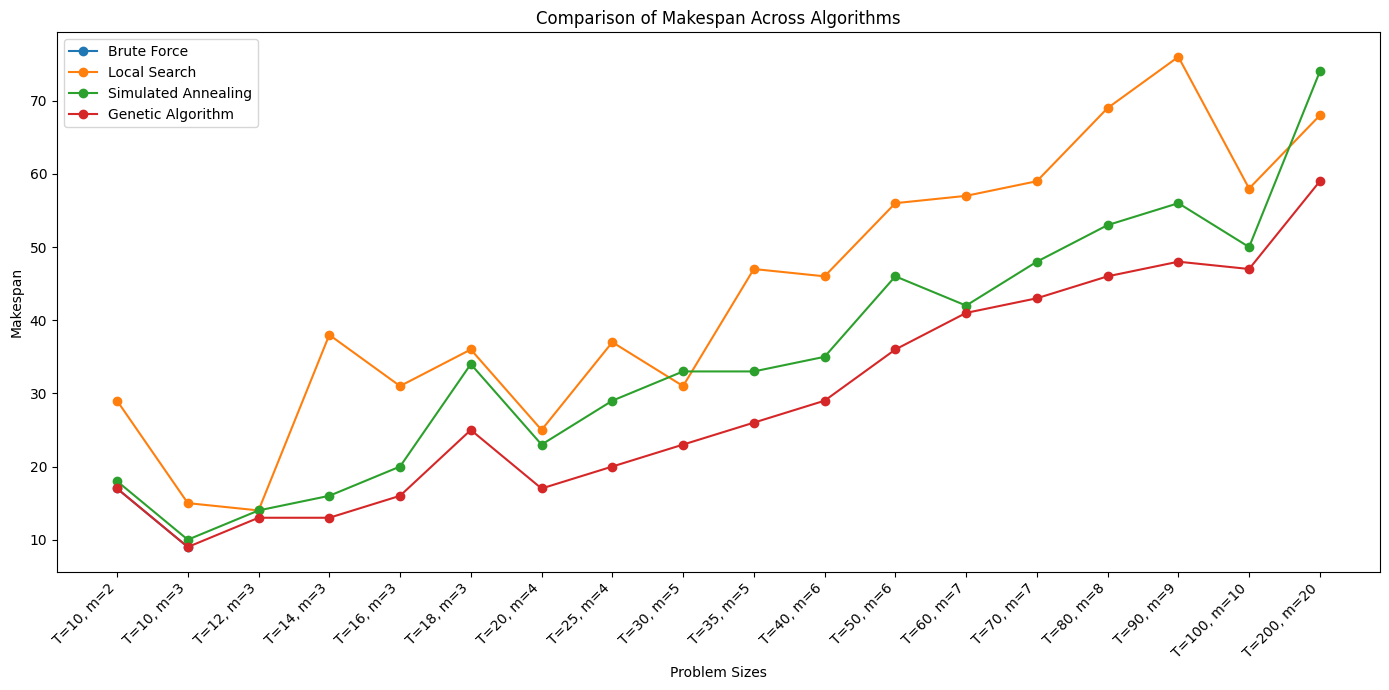

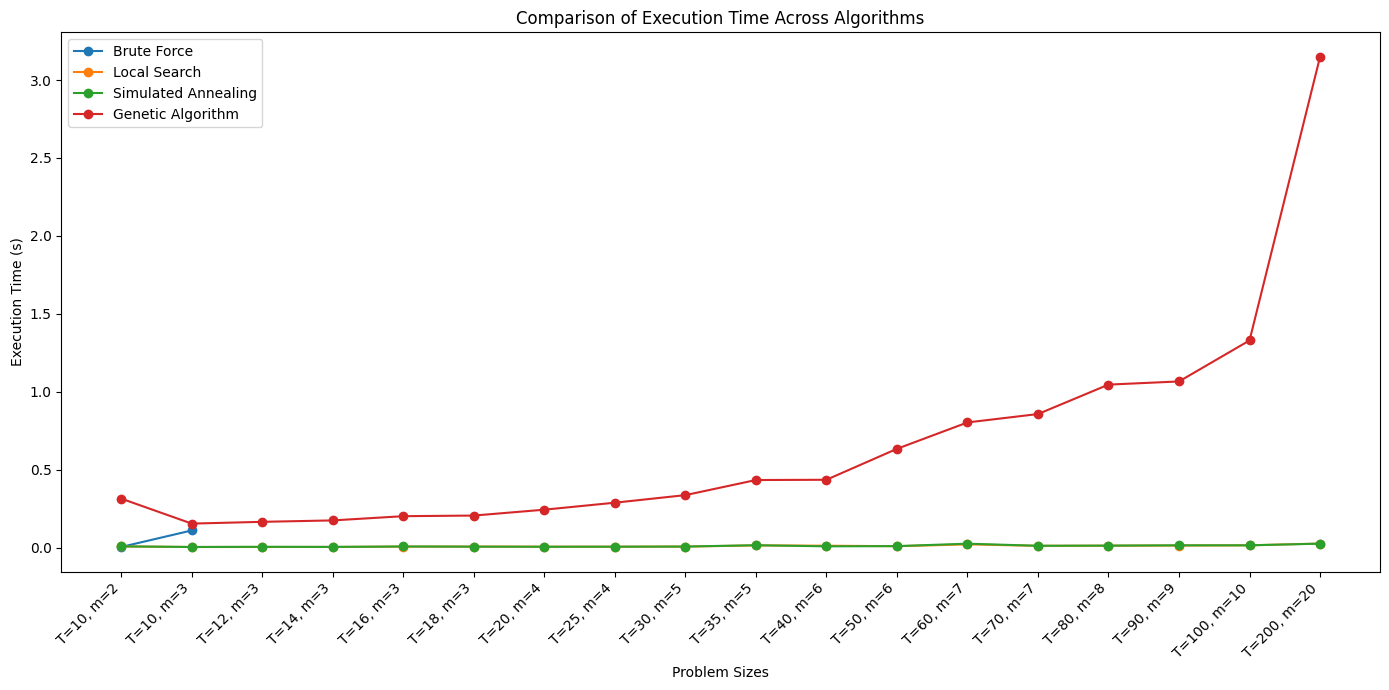

In [8]:
# prepare data for plotting
algorithms = ["Brute Force", "Local Search", "Simulated Annealing", "Genetic Algorithm"]
makespan_data = {algo: [] for algo in algorithms}
time_data = {algo: [] for algo in algorithms}
problem_sizes_labels = []

for result in all_results:
    T, m = result["Problem Size"]
    problem_sizes_labels.append(f"T={T}, m={m}")
    for algo_result in result["Algorithms"]:
        name = algo_result["Name"]
        makespan_data[name].append(algo_result["Makespan"] if algo_result["Makespan"] is not None else float('inf'))
        time_data[name].append(algo_result["Time"] if algo_result["Time"] is not None else float('inf'))

# plot makespan comparison
plt.figure(figsize=(14, 7))
for algo in algorithms:
    plt.plot(problem_sizes_labels, makespan_data[algo], marker='o', label=algo)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Problem Sizes")
plt.ylabel("Makespan")
plt.title("Comparison of Makespan Across Algorithms")
plt.legend()
plt.tight_layout()
plt.show()

# plot execution time comparison
plt.figure(figsize=(14, 7))
for algo in algorithms:
    plt.plot(problem_sizes_labels, time_data[algo], marker='o', label=algo)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Problem Sizes")
plt.ylabel("Execution Time (s)")
plt.title("Comparison of Execution Time Across Algorithms")
plt.legend()
plt.tight_layout()
plt.show()